<a href="https://colab.research.google.com/github/Alexander-Klug/Stock_Return_Signal_Detection/blob/main/StockSignal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Decision Tree and XGBoost**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from collections import Counter


# Parameters
N = 1_000_000  # Number of sequences
k = 30     # Length of each sequence
mu = 0     # Mean of the normal distribution (intra-day returns)
sigma = 1  # Standard deviation of the normal distribution
x = 50000    # Number of sequences with the signal
l = 8      # Number of consecutive increasing returns in the signal
confidence_threshold = 0.7  # Confidence threshold for making a prediction

# Step 1: Generate N sequences of length k from a normal distribution
returns = np.random.normal(mu, sigma, (N, k))

# Step 2: Pick x random sequences and modify their first l returns to be increasing
signal_indices = np.random.choice(N, x, replace=False)
for idx in signal_indices:
    #returns[idx, :l] = np.linspace(-0.4, 0.4, l)  # Consecutive increasing returns
    #returns[idx, :l] = np.sort(returns[idx, :l])

    # Pick a random start position uniformly between 0 and k-l (inclusive)
    start_idx = np.random.randint(0, k - l + 1)

    # Modify l consecutive entries, starting from start_idx
    returns[idx, start_idx:start_idx + l] = np.sort(returns[idx, start_idx:start_idx + l])


# Step 3: Assign the label +1 to these sequences
labels = np.full(N, np.nan)
labels[signal_indices] = 1

# Step 4: Assign random labels to the remaining sequences (proportions adjusted)
remaining_indices = np.setdiff1d(np.arange(N), signal_indices)
p_one = (N / 3 - x) / (N - x)  # Proportion for label +1
p_zero = (1 - p_one) / 2  # Proportion for label 0
p_neg_one = (1 - p_one) / 2  # Proportion for label -1

# Assign random labels to the remaining sequences using these proportions
random_labels = np.random.choice([1, 0, -1], size=len(remaining_indices), p=[p_one, p_zero, p_neg_one])
labels[remaining_indices] = random_labels

# Check the proportion of labels
label_counts = Counter(labels)
total_labels = sum(label_counts.values())

# Convert counts to proportions
label_proportions = {label: count / total_labels for label, count in label_counts.items()}
print("Label counts:", label_counts)
print("Label proportions:", label_proportions)

# Step 5: Map the labels for XGBoost
label_mapping = {-1: 0, 0: 1, 1: 2}
mapped_labels = np.vectorize(label_mapping.get)(labels)

# Split the data into training and test sets
X_train, X_test, y_train_mapped, y_test_mapped = train_test_split(returns, mapped_labels, test_size=0.3, random_state=42)

# Define the XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softprob', num_class=3)  # Use softprob to get probabilities
#model = DecisionTreeClassifier(random_state=42, max_depth=4,)

# Train the model
model.fit(X_train, y_train_mapped)

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_test)

# Apply confidence threshold
y_pred_mapped = []
unsure_count = 0

for prob in y_pred_proba:
    max_prob = np.max(prob)
    if max_prob > confidence_threshold:
        y_pred_mapped.append(np.argmax(prob))  # Predict class with highest probability
    else:
        y_pred_mapped.append(None)  # Mark as unsure
        unsure_count += 1

# Reverse mapping for test set and predictions
reverse_label_mapping = {0: -1, 1: 0, 2: 1}

# Convert predictions back to original labels or "unsure"
y_pred = []
for pred in y_pred_mapped:
    if pred is None:
        y_pred.append("unsure")
    else:
        y_pred.append(reverse_label_mapping[pred])

# Filter out "unsure" predictions for performance evaluation
confident_y_pred = [p for p in y_pred if p != "unsure"]
confident_y_test = [reverse_label_mapping[label] for i, label in enumerate(y_test_mapped) if y_pred[i] != "unsure"]

# Calculate how often the model is sure
total_predictions = len(y_pred)
sure_count = total_predictions - unsure_count
confidence_rate = sure_count / total_predictions

# Classification report (for confident predictions only)
print(f"Total predictions: {total_predictions}")
print(f"Confident predictions: {sure_count}")
print(f"Unsure predictions: {unsure_count}")
print(f"Confidence rate: {confidence_rate:.2f}")
print(f"Classification report for confident predictions:")

print(classification_report(confident_y_test, confident_y_pred, target_names=["-1", "0", "1"]))


Label counts: Counter({-1.0: 334037, 1.0: 333075, 0.0: 332888})
Label proportions: {-1.0: 0.334037, 0.0: 0.332888, 1.0: 0.333075}
Total predictions: 300000
Confident predictions: 588
Unsure predictions: 299412
Confidence rate: 0.00
Classification report for confident predictions:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        15
           0       0.00      0.00      0.00        21
           1       0.94      1.00      0.97       552

    accuracy                           0.94       588
   macro avg       0.31      0.33      0.32       588
weighted avg       0.88      0.94      0.91       588



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Neural Network**

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Parameters
N = 1_000_000  # Number of sequences
k = 30     # Length of each sequence
mu = 0     # Mean of the normal distribution (intra-day returns)
sigma = 1  # Standard deviation of the normal distribution
x = 50000    # Number of sequences with the signal
l = 8      # Number of consecutive increasing returns in the signal
confidence_threshold = 0.7  # Confidence threshold for making a prediction

# Step 1: Generate N sequences of length k from a normal distribution
returns = np.random.normal(mu, sigma, (N, k))

# Step 2: Pick x random sequences and modify their first l returns to be increasing
signal_indices = np.random.choice(N, x, replace=False)
for idx in signal_indices:
    #returns[idx, :l] = np.linspace(-0.4, 0.4, l)  # Consecutive increasing returns
    #returns[idx, :l] = np.sort(returns[idx, :l])

    # Pick a random start position uniformly between 0 and k-l (inclusive)
    start_idx = np.random.randint(0, k - l + 1)

    # Modify l consecutive entries, starting from start_idx
    returns[idx, start_idx:start_idx + l] = np.sort(returns[idx, start_idx:start_idx + l])

# Step 3: Assign the label +1 to these sequences
labels = np.full(N, np.nan)
labels[signal_indices] = 1

# Step 4: Assign random labels to the remaining sequences (proportions adjusted)
remaining_indices = np.setdiff1d(np.arange(N), signal_indices)
p_one = (N / 3 - x) / (N - x)  # Proportion for label +1
p_zero = (1 - p_one) / 2  # Proportion for label 0
p_neg_one = (1 - p_one) / 2  # Proportion for label -1

# Assign random labels to the remaining sequences using these proportions
random_labels = np.random.choice([1, 0, -1], size=len(remaining_indices), p=[p_one, p_zero, p_neg_one])
labels[remaining_indices] = random_labels

# Check the proportion of labels
label_counts = Counter(labels)
total_labels = sum(label_counts.values())

# Convert counts to proportions
label_proportions = {label: count / total_labels for label, count in label_counts.items()}
print("Label counts:", label_counts)
print("Label proportions:", label_proportions)

# Step 5: Map the labels for the neural network
label_mapping = {-1: 0, 0: 1, 1: 2}
mapped_labels = np.vectorize(label_mapping.get)(labels)

# One-hot encode the labels for NN
y_one_hot = to_categorical(mapped_labels, num_classes=3)

# Split the data into training and test sets
X_train, X_test, y_train_one_hot, y_test_one_hot = train_test_split(returns, y_one_hot, test_size=0.3, random_state=42)

# Define the neural network
model = Sequential([
    Dense(64, input_shape=(k,), activation='relu'),  # First hidden layer with 64 units
    Dense(32, activation='relu'),  # Second hidden layer with 32 units
    Dense(3, activation='softmax')  # Output layer with 3 units for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)

# Get predicted probabilities
y_pred_proba = model.predict(X_test)

# Apply confidence threshold
y_pred_mapped = []
unsure_count = 0

for prob in y_pred_proba:
    max_prob = np.max(prob)
    if max_prob > confidence_threshold:
        y_pred_mapped.append(np.argmax(prob))  # Predict class with highest probability
    else:
        y_pred_mapped.append(None)  # Mark as unsure
        unsure_count += 1

# Reverse mapping for test set and predictions
reverse_label_mapping = {0: -1, 1: 0, 2: 1}

# Convert predictions back to original labels or "unsure"
y_pred = []
for pred in y_pred_mapped:
    if pred is None:
        y_pred.append("unsure")
    else:
        y_pred.append(reverse_label_mapping[pred])

# Filter out "unsure" predictions for performance evaluation
confident_y_pred = [p for p in y_pred if p != "unsure"]
confident_y_test = [reverse_label_mapping[np.argmax(label)] for i, label in enumerate(y_test_one_hot) if y_pred[i] != "unsure"]

# Calculate how often the model is sure
total_predictions = len(y_pred)
sure_count = total_predictions - unsure_count
confidence_rate = sure_count / total_predictions

# Classification report (for confident predictions only)
print(f"Total predictions: {total_predictions}")
print(f"Confident predictions: {sure_count}")
print(f"Unsure predictions: {unsure_count}")
print(f"Confidence rate: {confidence_rate:.2f}")
print(f"Classification report for confident predictions:")

print(classification_report(confident_y_test, confident_y_pred, target_names=["-1", "0", "1"]))


Label counts: Counter({-1.0: 333800, 0.0: 333357, 1.0: 332843})
Label proportions: {0.0: 0.333357, -1.0: 0.3338, 1.0: 0.332843}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.3412 - loss: 1.1011 - val_accuracy: 0.3523 - val_loss: 1.0958
Epoch 2/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.3543 - loss: 1.0944 - val_accuracy: 0.3614 - val_loss: 1.0899
Epoch 3/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.3654 - loss: 1.0862 - val_accuracy: 0.3713 - val_loss: 1.0782
Epoch 4/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.3734 - loss: 1.0748 - val_accuracy: 0.3768 - val_loss: 1.0704
Epoch 5/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.3778 - loss: 1.0678 - val_accuracy: 0.3783 - val_loss: 1.0661
Epoch 6/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.3775 - loss: 1.0643 - val_accuracy: 0.3767 - val_loss: 1.0627
Epoch 7/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.3789 - loss: 1.0615 - val_accuracy: 0.3803 - val_loss: 1.0616
Epoch 8/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Probability that a sequence of length k as l consecutive numbers that are increasing**

In [ ]:
import numpy as np
from math import factorial

def has_increasing_subsequence(sequence, l):
    """
    Check if a sequence has any l consecutive increasing numbers.
    """
    for i in range(len(sequence) - l + 1):
        if np.all(np.diff(sequence[i:i + l]) > 0):
            return True
    return False

def analytical_probability(k, l):
    """
    Compute the analytical probability of finding at least one increasing subsequence
    of length l in a sequence of length k.
    """
    p_increasing = 1 / factorial(l)  # Probability that a subsequence of length l is increasing
    num_subsequences = k - l + 1  # Number of possible subsequences of length l
    return 1 - (1 - p_increasing) ** num_subsequences

def simulation_probability(k, l, num_sequences=10000):
    """
    Estimate the probability that a random sequence of length k has
    l consecutive increasing numbers.
    """
    increasing_count = 0
    for _ in range(num_sequences):
        sequence = np.random.normal(0, 1, k)
        if has_increasing_subsequence(sequence, l):
            increasing_count += 1
    return increasing_count / num_sequences

def compare_probabilities(k, l, num_sequences=10000):
    """
    Compare the analytical and simulated probabilities for finding l consecutive increasing
    numbers in a sequence of length k.
    """
    # Analytical solution
    analytical_prob = analytical_probability(k, l)

    # Simulation solution
    sim_prob = simulation_probability(k, l, num_sequences)

    return analytical_prob, sim_prob

# Example usage
k = 30  # Sequence length
l = 8   # Consecutive increasing numbers

analytical_prob, sim_prob = compare_probabilities(k, l, num_sequences=5000)

print(f"Analytical Probability: {analytical_prob}")
print(f"Simulated Probability: {sim_prob}")


Analytical Probability: 0.0005702809099114026
Simulated Probability: 0.0004


In [ ]:
print(N)
print(N*sim_prob)

1000000
400.0


# **Other**

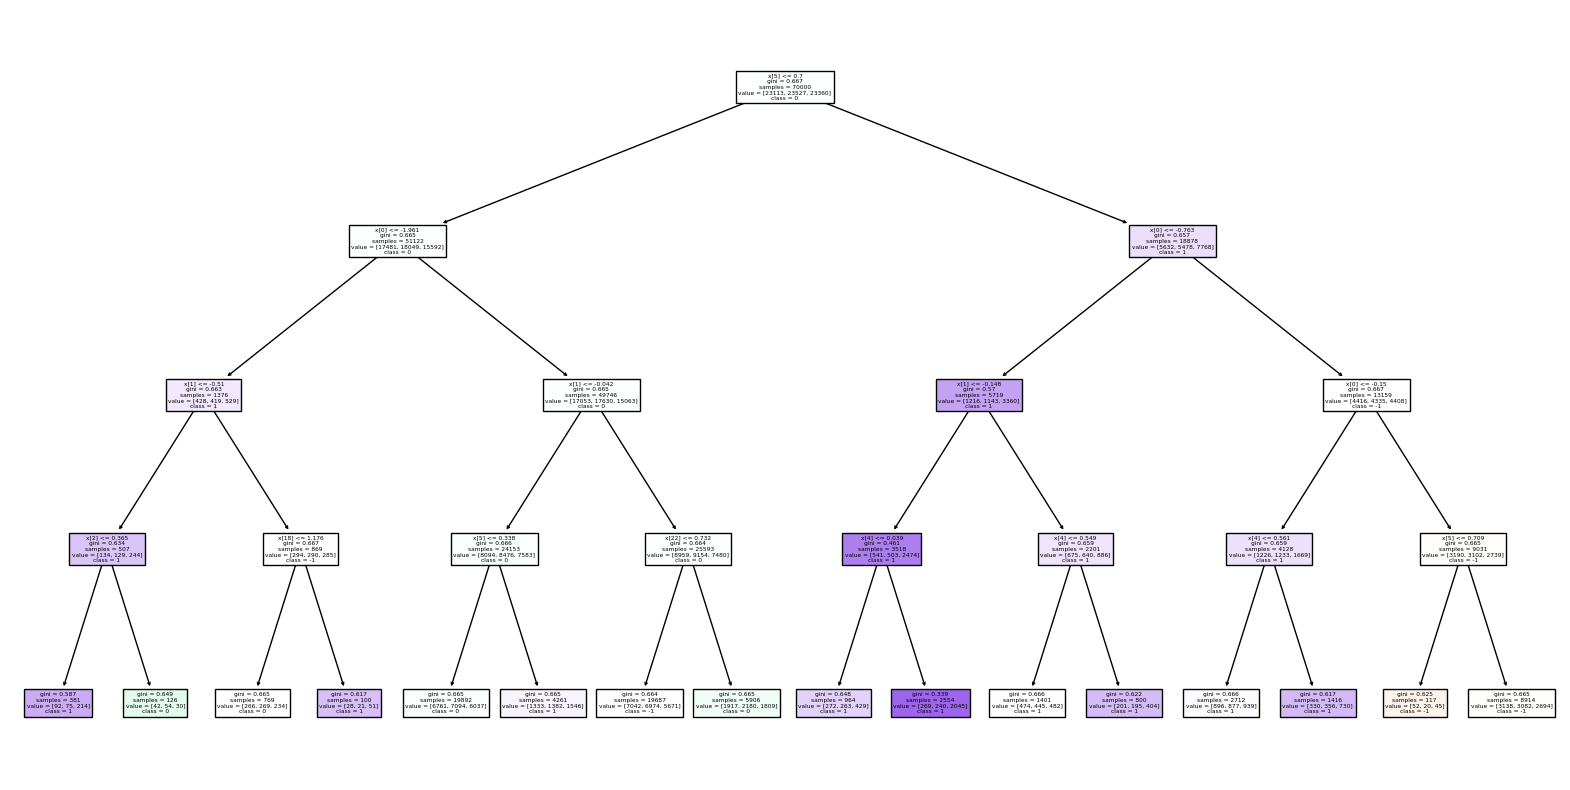

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming 'model' is your trained decision tree classifier
plt.figure(figsize=(20, 10))  # Adjust the size to fit the entire tree
plot_tree(model, filled=True, feature_names=None, class_names=["-1", "0", "1"])
plt.savefig('decision_tree.png', dpi=1000)
plt.show()


In [ ]:
returns[signal_indices[1]]

array([-1.48490271, -0.44794671, -0.3269095 ,  0.40106296,  0.41267584,
        2.50225089,  0.61095456, -1.4439162 ,  1.54908072,  2.11841622,
        0.02576867,  1.04230339, -0.5812976 , -0.67959325,  1.35796512,
       -0.63158879, -0.64549481, -1.33293276, -0.74115668, -1.07480094,
       -0.62141098,  0.40430814, -0.73035074,  0.05645198,  0.729446  ,
        1.23336153, -1.73068036, -0.93215542,  0.27180942,  0.52440445])

<Figure size 1500x1000 with 0 Axes>

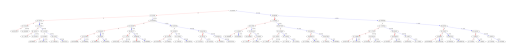

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 10))
xgb.plot_tree(model, num_trees=0)
plt.savefig('xgb_tree.png', dpi=1400)
plt.show()